In [2]:
import numpy as np
from matplotlib import pyplot as plt
import timeit

%matplotlib inline

import montecarlo as mc
%load_ext autoreload
%autoreload 2

In [3]:
def cython_mcmc(N_steps = 10**4,
                N_system = 1000,
                mu = 0,
                beta = 0.1,
                V=1,
                alpha=1.5,
                return_names = False,
                sample_output = False,
                **kwargs,
               ):

    #python setup code goes here
    state = np.arange(N_system, dtype = np.int64) % 2
    M = mc.interaction_matrix(N=N_system, alpha=alpha, V=V)

    energies = np.zeros(shape = N_steps, dtype = np.float64)
    numbers = np.zeros(shape = N_steps, dtype = np.int64)
    magnetisations = np.zeros(shape = N_steps, dtype = np.int64)

    alternating_signs, ut, t, background = mc.initialise_state_representations(state, interaction_matrix=M)

    #if sample_output is true, we just want to get the shape of the data
    if not sample_output:
        mc.cython_mcmc_helper(
                    #outputs
                    energies,
                    numbers,
                    magnetisations,

                    #inputs
                    state,
                    alternating_signs,
                    ut,
                    t,
                    background,
                    M,

                    #parameters
                    N_steps,
                    N_system,
                    mu,
                    beta,
                    V,
                    alpha,
                   )
    
    if return_names == True:
        return ('energies', 'numbers', 'magnetisations'), (energies, numbers, magnetisations)
    return energies, numbers, magnetisations

In [ ]:
config = dict(N_steps = 10**3,
                N_system = 101,
                mu = 0,
                beta = 0.7,
                V=-1,
                alpha=1.5,
               )

#mc.py_srand48(52)
%time energies, numbers, magnetisations = cython_mcmc(**config)

print(f'''
E: {energies.mean()}
N: {numbers.mean()}
M: {magnetisations.mean()}
''')

f, axs = plt.subplots(4, figsize = (16,7))
axs[0].plot(energies, label = 'energy')
axs[1].plot(numbers, label = 'number')
axs[2].plot(magnetisations, label = 'magnetisation')
axs[3].plot(magnetisations**2, label = 'magnetisation ^ 2')

for a in axs: a.legend()

In [ ]:
config = dict(N_steps = 10**5,
                N_system = 101,
                mu = 0,
                beta = 0.7,
                V=-1,
                alpha=1.5,
               )

#mc.py_srand48(52)
%time lenergies, lnumbers, lmagnetisations = cython_mcmc(**config)

In [ ]:
def autocorrelation(O):
    Ob = O/O.mean() - 1
    return np.correlate(Ob, Ob, mode = 'full') / len(O)**2

f, axs = plt.subplots(2, figsize = (16,7))
axs[1].plot(autocorrelation(lenergies), label = 'energy autocorr')
axs[0].plot(autocorrelation(lmagnetisations), label = 'mag autocorr')
axs[1].plot(autocorrelation(lnumbers), label = 'number autocorr')
axs[1].plot(autocorrelation(lmagnetisations**2), label = 'mag^2 autocorr')

N = len(lenergies)
print(N)
d = 500
d2 = 100
axs[0].set(xlim = (N-d,N+d))
axs[1].set(xlim = (N-d2,N+d2))
for a in axs: a.legend()

In [ ]:
def default_mcmc(**config_updates):
    config = dict(N_steps = 10**3,
                N_system = 100,
                mu = 0,
                beta = 1,
                V=-1,
                alpha=1.5,
               )
    config.update(config_updates)

    mc.py_srand48(42)
    energies, numbers, magnetisations = cython_mcmc(**config)
    
    return energies / config['N_system'], numbers / config['N_system'], magnetisations / config['N_system']

f, axs = plt.subplots(2, figsize = (16,7))
betas = np.linspace(0.5,1,30)

for i in [4,5,6,7,8]:
    mc.py_srand48(42)
    energies, numbers, magnetisations = cython_mcmc(**config)
    
    #axis 0 = beta, axis 2 = e, n, m, axis 3 = mcmc steps
    out = np.array([default_mcmc(beta=beta, N_system=2**i) for beta in betas])
    e,n,m = out[:, 0, :],out[:, 1, :],out[:, 2, :]
    
    
    axs[0].plot(betas, (m**2).mean(axis=1), label = f'm^2 N=2**{i}')
    axs[1].plot(betas, 1-(m**4).mean(axis=1)/(m**2).mean(axis=1)**2, label = f'm^2 N=2**{i}')

for a in axs: a.legend()

In [ ]:
betas = np.linspace(0.2,1,10)
f, axs = plt.subplots(2, figsize = (16,7))

for beta in betas:
    energies, numbers, magnetisations = cython_mcmc(
                N_steps = 10**3,
                N_system = 100,
                mu = 0,
                beta = beta,
                V=-1,
                alpha=1.5)
    
    axs[0].hist(beta * energies, normed = True, alpha = 0.5, bins = 10)
    

In [4]:
import h5py
from pathlib import Path

#make a job, take a config spec:
config = dict(N_steps = 10**3,
              N_system = np.arange(100,150, dtype = np.int),
              mu = 0,
              beta = np.linspace(0.2,1.1,60, dtype = np.double),
              V=-1,
              alpha=1.5,
              return_names = True,
              #this is necessary for hd5 to know how to save it
              loop_over = np.array(['N_system', 'beta'], dtype=h5py.special_dtype(vlen=str)),
            )

from jobmanager import config_dimensions, total_jobs, get_config, run_mcmc

config_dimensions(config)

(array(['N_system', 'beta'], dtype=object),
 array([ array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]),
        array([ 0.2       ,  0.21525424,  0.23050847,  0.24576271,  0.26101695,
         0.27627119,  0.29152542,  0.30677966,  0.3220339 ,  0.33728814,
         0.35254237,  0.36779661,  0.38305085,  0.39830508,  0.41355932,
         0.42881356,  0.4440678 ,  0.45932203,  0.47457627,  0.48983051,
         0.50508475,  0.52033898,  0.53559322,  0.55084746,  0.56610169,
         0.58135593,  0.59661017,  0.61186441,  0.62711864,  0.64237288,
         0.65762712,  0.67288136,  0.68813559,  0.70338983,  0.71864407,
         0.73389831,  0.74915254,  0.76440678,  0.77966102,  0.79491525,
         0.81016949,  0.82542373,  0.84067797,  0.8559322 ,  0.87118644,


In [4]:
get_config(5, config)        

{'N_steps': 1000,
 'N_system': 100,
 'V': -1,
 'alpha': 1.5,
 'beta': 0.276271186440678,
 'indices': (0, 5),
 'job_number': 0,
 'loop_over': array(['N_system', 'beta'], dtype=object),
 'mu': 0,
 'return_names': True}

In [37]:
config = dict(N_steps = 10**5,
              N_system = np.array([50,100,200,400]),
              mu = 0,
              beta = np.linspace(0.2,1.1,10, dtype = np.double),
              V=-1,
              alpha=1.5,
              return_names = True,
              #this is necessary for hd5 to know how to save it
              loop_over = np.array(['N_system', 'beta'], dtype=h5py.special_dtype(vlen=str)),
            )
N = total_jobs(config)
print(N)
for i in range(N):
    run_mcmc(cython_mcmc, config, i, working_dir = Path('/home/tch14/workspace/fk_mcmc_data'))

40


In [7]:
import numpy as np
from jobmanager import setup_mcmc, run_mcmc, gather_mcmc

config = dict(N_steps = 10**4,
              N_system = np.array([50,100,200,400,500]),
              mu = 0,
              beta = np.linspace(0.2,1.1,10, dtype = np.double),
              V=-1,
              alpha=1.5,
              return_names = True,
              #this is necessary for hd5 to know how to save it
              loop_over = np.array(['N_system', 'beta'], dtype=h5py.special_dtype(vlen=str)),
            )
working_dir = Path('/home/tch14/workspace/fk_mcmc_data')
setup_mcmc(cython_mcmc, config, working_dir)

['energies', 'magnetisations', 'numbers']


In [13]:
import multiprocessing as mlti
    
def run(i): 
    run_mcmc(cython_mcmc, i, working_dir)
    print(f'done {i}!')

print(f'total jobs: {total_jobs(config)}')
with mlti.Pool(processes = 24) as pool:
    pool.map(run, range(total_jobs(config)))

total jobs: 50
done 2!
done 4!
done 1!
done 0!
done 3!
done 5!
done 7!
done 8!
done 6!
done 9!
done 10!
done 11!
done 12!
done 13!
done 14!
done 15!
done 16!
done 17!
done 18!
done 19!
done 20!
done 23!
done 21!
done 22!
done 24!
done 25!
done 27!
done 29!
done 26!
done 28!
done 32!
done 31!
done 33!
done 30!
done 34!
done 35!
done 36!
done 40!
done 39!
done 38!
done 42!
done 37!
done 41!
done 43!
done 44!
done 45!
done 49!
done 46!
done 48!
done 47!


In [14]:
gather_mcmc(working_dir, overwrite = True)

['energies', 'magnetisations', 'numbers']
['N_system' 'beta']


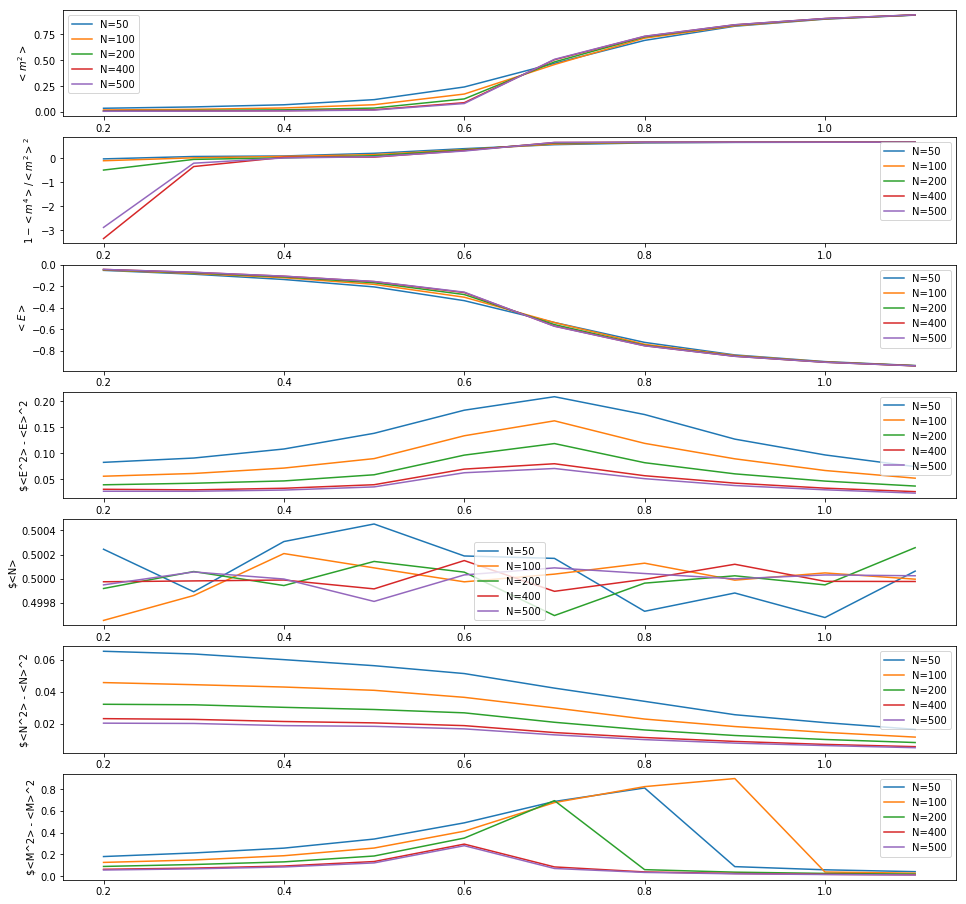

In [15]:
result_filename = Path('/home/tch14/workspace/fk_mcmc_data/results.hdf5')

with h5py.File(result_filename, 'r+') as data:
    print(list(data.keys()))
    print(data.attrs['loop_over'])
    
    f, axs = plt.subplots(7, figsize = (16,16))
    
    betas = data.attrs['beta']
    N_systems = data.attrs['N_system']

    for i,N_system in enumerate(N_systems):
        #axis 0 = N_system axis 1 = beta

        e = data['energies'][i, :, :] / N_system
        m = data['magnetisations'][i, :, :] /  N_system
        n = data['numbers'][i, :, :] /  N_system
        
        axs[0].plot(betas, (m**2).mean(axis=-1), label = f'N={N_system}')
        axs[0].set(ylabel = r'$<m^2>$')
        axs[1].plot(betas, 1-(m**4).mean(axis=-1)/(m**2).mean(axis=1)**2/3, label = f'N={N_system}')
        axs[1].set(ylabel = r'$1-<m^4>/<m^2>^2$')
        
        axs[2].plot(betas, e.mean(axis=-1), label = f'N={N_system}')
        axs[2].set(ylabel = r'$<E>$')
        axs[3].plot(betas, e.std(axis=-1), label = f'N={N_system}')
        axs[3].set(ylabel = r'$<E^2> - <E>^2')
        
        axs[4].plot(betas, n.mean(axis=-1), label = f'N={N_system}')
        axs[4].set(ylabel = r'$<N>')
        axs[5].plot(betas, n.std(axis=-1), label = f'N={N_system}')
        axs[5].set(ylabel = r'$<N^2> - <N>^2')
        
        axs[6].plot(betas, m.std(axis=-1), label = f'N={N_system}')
        axs[6].set(ylabel = r'$<M^2> - <M>^2')

    for a in axs: a.legend()
    